<a href="https://colab.research.google.com/github/noahruiz416/Homelessness_Clustering_Comparisons/blob/master/Homeless_Clustering_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OBJECTIVE (Copied from David Little):

This project consists of 4 distinct tasks revolving around a dataset tracking the services used by homeless people in Maricopa county, Arizona. The overarching objective was to design a risk model that assessed the likelihood of people falling back into homelessness after utilizing certain services. An essential component of this was to identify natural clusters of usage patterns within the data. This allowed us to observe how distinct groups of people flowed through the system and to identify success stories within the data. While our team settled on the BIRCH algorithm, we are interested in identifying other clustering algorithms that may be more efficient or may tell us an interesting story from the data. We are interested in any approach identified. 



Author of this notebook: Noah Ruiz

This specific file is an initial EDA + Model Exploration of the various tasks, within this file we hope to gain a better understanding of the various services used, to provide better insight into the behavior of homeless people. In my specific implementation I hope to improve hyperparameter tuning, implement various distance metrics, apply new visualiztion technqiues and introduce various approaches to clustering, to try and gain a better understaning of homeless activity.

Final models for this project will be posted in a .py file within the same repo as this file

## Data Imports + Initial Checks

In [1]:
#imports 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns 

In [2]:
#loading the data
url = 'https://raw.githubusercontent.com/djlittle/Homelessness_Clustering_Comparisons/master/Data/HMIS%20Data%20Extract.csv'

initial_df = pd.read_csv(url) # Importing data

print(initial_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29345 entries, 0 to 29344
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   personalid               29345 non-null  int64  
 1   projecttype_1_bednights  9832 non-null   float64
 2   projecttype_1_count      9832 non-null   float64
 3   projecttype_2_count      1520 non-null   float64
 4   projecttype_3_count      1731 non-null   float64
 5   projecttype_4_count      7351 non-null   float64
 6   projecttype_6_count      2211 non-null   float64
 7   projecttype_7_count      8041 non-null   float64
 8   projecttype_8_count      66 non-null     float64
 9   projecttype_10_count     114 non-null    float64
 10  projecttype_12_count     228 non-null    float64
 11  projecttype_13_count     3257 non-null   float64
 12  projecttype_14_count     17334 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 2.9 MB
None


In [3]:
#count of null values 
initial_df.isna().sum() #large amounts of null values

personalid                     0
projecttype_1_bednights    19513
projecttype_1_count        19513
projecttype_2_count        27825
projecttype_3_count        27614
projecttype_4_count        21994
projecttype_6_count        27134
projecttype_7_count        21304
projecttype_8_count        29279
projecttype_10_count       29231
projecttype_12_count       29117
projecttype_13_count       26088
projecttype_14_count       12011
dtype: int64

In [4]:
#number of unique ids / people
initial_df['personalid'].value_counts().count()

29345

In [5]:
##initial eda 
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29345 entries, 0 to 29344
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   personalid               29345 non-null  int64  
 1   projecttype_1_bednights  9832 non-null   float64
 2   projecttype_1_count      9832 non-null   float64
 3   projecttype_2_count      1520 non-null   float64
 4   projecttype_3_count      1731 non-null   float64
 5   projecttype_4_count      7351 non-null   float64
 6   projecttype_6_count      2211 non-null   float64
 7   projecttype_7_count      8041 non-null   float64
 8   projecttype_8_count      66 non-null     float64
 9   projecttype_10_count     114 non-null    float64
 10  projecttype_12_count     228 non-null    float64
 11  projecttype_13_count     3257 non-null   float64
 12  projecttype_14_count     17334 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 2.9 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3303fc650>,
      dtype=object)

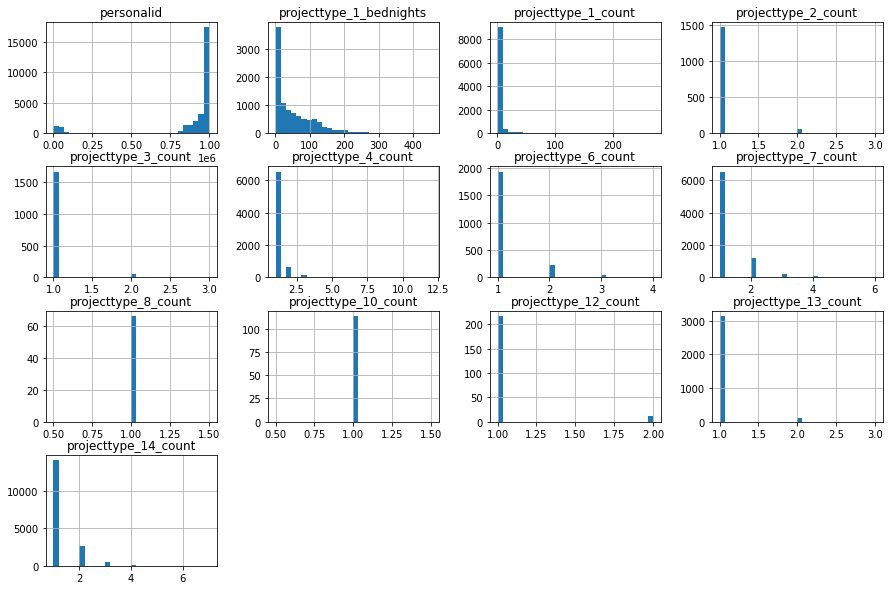

In [6]:
initial_df.hist(bins = 30, figsize=(15, 10))

In [7]:
#visualizing each project variable in 1 dimension
def plot_one(input_data, var_name):
  dat = np.array(input_data[f'{var_name}'])
  plt.scatter(dat.flatten(), [0]*len(dat))

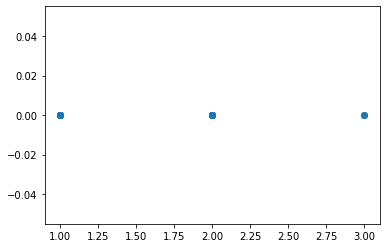

In [8]:
plot_one(initial_df, 'projecttype_2_count')

In [9]:
#renaming columns based off the data dictionary
initial_df.rename(columns={'projecttype_1_bednights':'ESNights', 'projecttype_1_count':'ES',
                   'projecttype_2_count': 'TransitionalHousing', 'projecttype_3_count': 'PH'
                   ,'projecttype_4_count': 'StreetOutReach', 'projecttype_6_count': 'ServicesOnly', 
                   'projecttype_7_count': 'Other', 'projecttype_8_count': 'SafeHaven', 'projecttype_10_count': 'PH-NoDis',
                   'projecttype_12_count': 'HomelessPrev', 'projecttype_13_count': 'PHRapid',
                   'projecttype_14_count': 'CoordinatedAsses'}, inplace=True)

## Data Cleaning Portion

In [10]:
#dealing with null values, 
df = initial_df.iloc[:, 1:]
df.fillna(0, inplace=True) # Filling null values of the data frame with -1. 
# Other approaches to null handling are also of interest here.

df.isna().sum() # clears all null values and replaces them with -1 

df_personalID = initial_df.iloc[:, 0:]
df_personalID.fillna(-1, inplace=True)

## Initial Exploratory Analysis 

Large amount of imbalance based on analyzing the initial values, many of the homeless did not use any servies at all, whereas certain homeless used services quite frequently

In [11]:
#here we create an an aggregated usage variable that has a count of the total amount of services that a person utilized
#doing this reveals several linear relationships 
aggregate_usage = df.sum(axis=1)
df['TotalUsage'] = aggregate_usage

In [65]:
df.corr()

ESNights        ES  TransitionalHousing        PH  \
ESNights             1.000000  0.382378            -0.030338 -0.022844   
ES                   0.382378  1.000000            -0.025503  0.022899   
TransitionalHousing -0.030338 -0.025503             1.000000 -0.042246   
PH                  -0.022844  0.022899            -0.042246  1.000000   
StreetOutReach       0.027687  0.018092            -0.038402 -0.015518   
ServicesOnly         0.236919  0.178304            -0.026290  0.040412   
Other                0.093735  0.058126            -0.065714 -0.051417   
SafeHaven           -0.012453 -0.004438             0.019694 -0.011629   
PH-NoDis            -0.020765 -0.005212            -0.014308 -0.015296   
HomelessPrev        -0.032666 -0.012803            -0.013695 -0.021232   
PHRapid              0.251607  0.011590             0.060848 -0.064059   
CoordinatedAsses     0.283099  0.034341            -0.012799 -0.108235   
TotalUsage           0.971672  0.588850            -0.029524 -0.011729   
kmeans              -0.043489  0.026596            -0.116860  0.238336   
dbscan               0.049890 -0.181472             0.007065 -0.028604   
birch               -0.764480 -0.216390             0.025115  0.023897   
Isolation Score     -0.381810 -0.550407            -0.013306 -0.055928   

                     StreetOutReach  ServicesOnly     Other  SafeHaven  \
ESNights                   0.027687      0.236919  0.093735  -0.012453   
ES                         0.018092      0.178304  0.058126  -0.004438   
TransitionalHousing       -0.038402     -0.026290 -0.065714   0.019694   
PH                        -0.015518      0.040412 -0.051417  -0.011629   
StreetOutReach             1.000000      0.020884 -0.048497   0.002591   
ServicesOnly               0.020884      1.000000  0.088613  -0.008199   
Other                     -0.048497      0.088613  1.000000  -0.013061   
SafeHaven                  0.002591     -0.008199 -0.013061   1.000000   
PH-NoDis                  -0.021501     -0.004862 -0.022404  -0.002965   
HomelessPrev              -0.041630      0.006884 -0.039317  -0.004116   
PHRapid                    0.007974      0.024091 -0.021894   0.005242   
CoordinatedAsses          -0.001595      0.043551  0.017792   0.016494   
TotalUsage                 0.038854      0.259337  0.107982  -0.010866   
kmeans                     0.163097      0.062009  0.202817  -0.027240   
dbscan                    -0.015409     -0.142249 -0.096034  -0.005447   
birch                     -0.022227     -0.175889 -0.080235   0.010062   
Isolation Score           -0.123354     -0.238382 -0.121366  -0.002447   

                     PH-NoDis  HomelessPrev   PHRapid  CoordinatedAsses  \
ESNights            -0.020765     -0.032666  0.251607          0.283099   
ES                  -0.005212     -0.012803  0.011590          0.034341   
TransitionalHousing -0.014308     -0.013695  0.060848         -0.012799   
PH                  -0.015296     -0.021232 -0.064059         -0.108235   
StreetOutReach      -0.021501     -0.041630  0.007974         -0.001595   
ServicesOnly        -0.004862      0.006884  0.024091          0.043551   
Other               -0.022404     -0.039317 -0.021894          0.017792   
SafeHaven           -0.002965     -0.004116  0.005242          0.016494   
PH-NoDis             1.000000     -0.005413  0.008098         -0.034540   
HomelessPrev        -0.005413      1.000000 -0.020227         -0.074557   
PHRapid              0.008098     -0.020227  1.000000          0.144145   
CoordinatedAsses    -0.034540     -0.074557  0.144145          1.000000   
TotalUsage          -0.019214     -0.031962  0.229344          0.268787   
kmeans               0.115557      0.097475 -0.361030         -0.561399   
dbscan               0.001224      0.001756  0.091354          0.019521   
birch                0.015430      0.028428 -0.229441         -0.229641   
Isolation Score     -0.010219      0.005078 -0.113852         -0.136160   

    

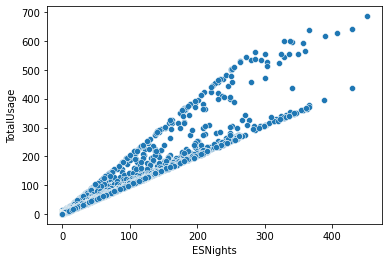

In [13]:
sns.scatterplot(x = df['ESNights'],  y = df['TotalUsage'])

In [14]:
initial_df.groupby('personalid').sum().max()

ESNights               451.0
ES                     269.0
TransitionalHousing      3.0
PH                       3.0
StreetOutReach          12.0
ServicesOnly             4.0
Other                    6.0
SafeHaven                1.0
PH-NoDis                 1.0
HomelessPrev             2.0
PHRapid                  3.0
CoordinatedAsses         7.0
dtype: float64

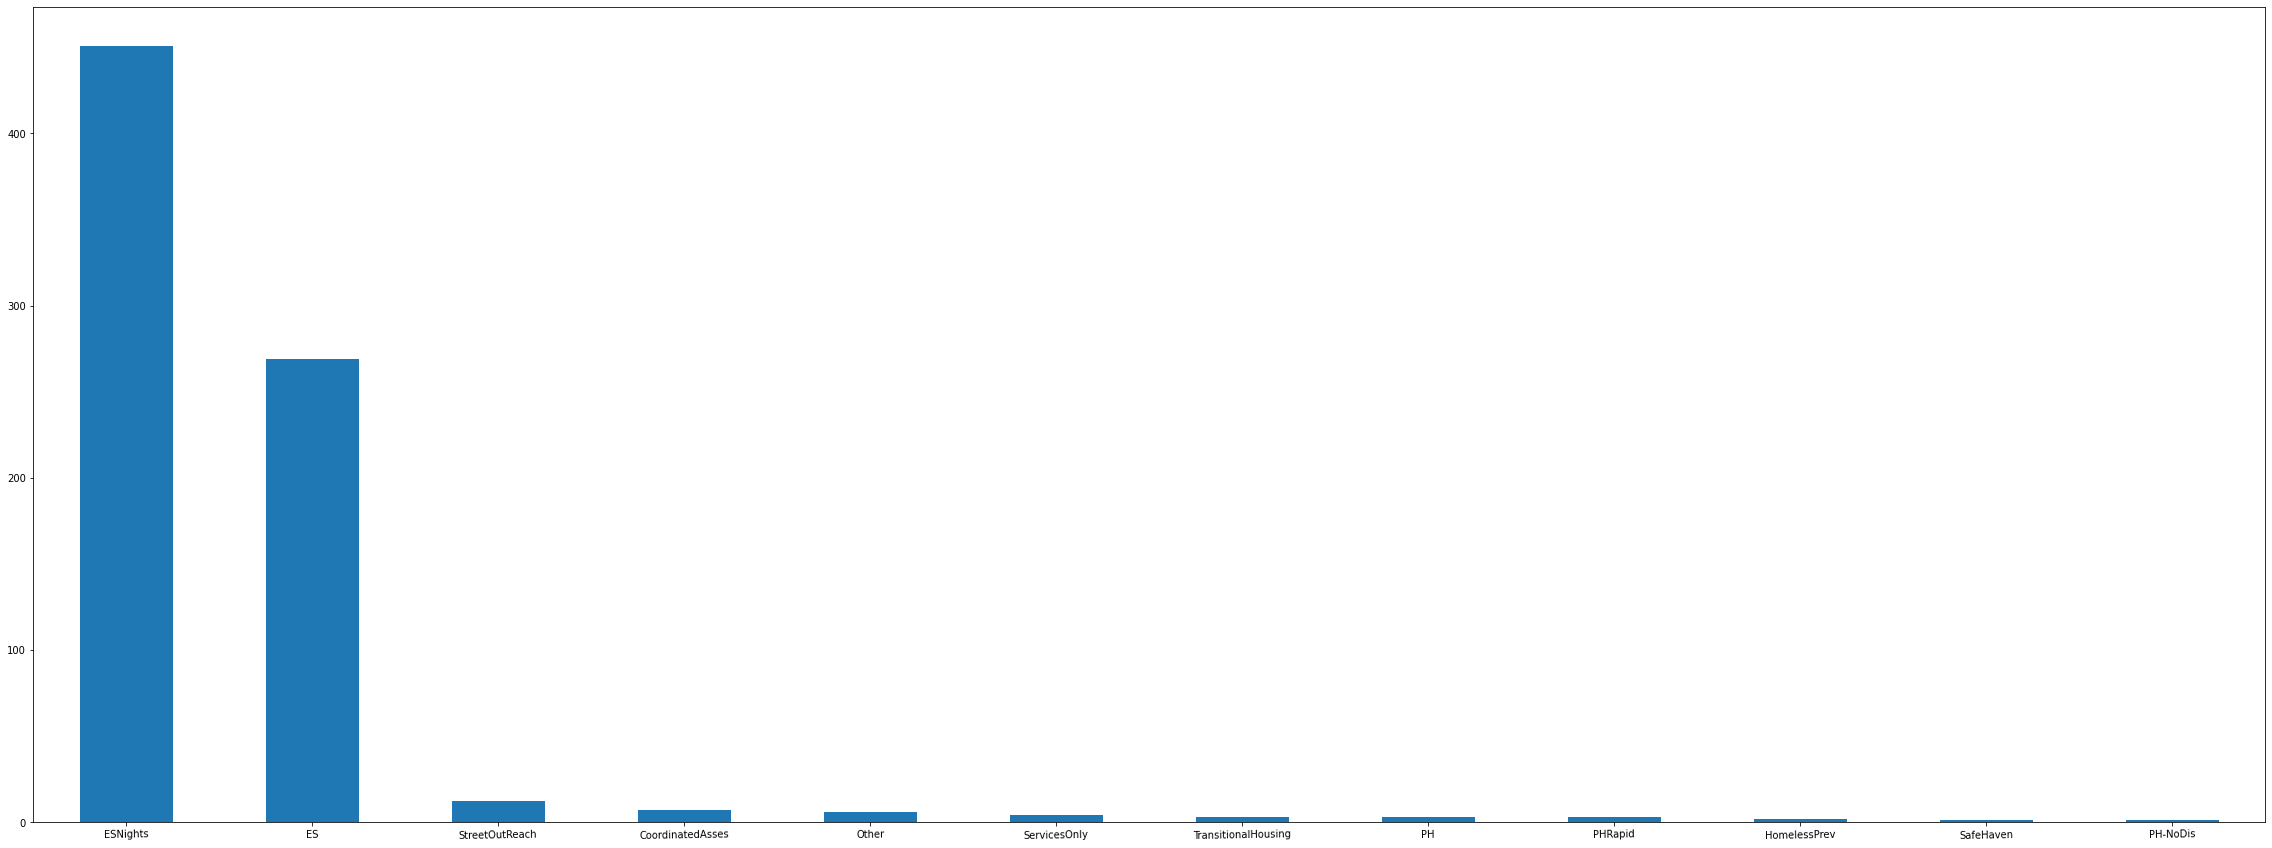

In [15]:
#graphing the max values of each service
initial_df.groupby('personalid').sum().max().sort_values(ascending=False).plot.bar(figsize=(40, 15), rot = 1)

In [16]:
#getting an idea of the most used services
initial_df.groupby('personalid').count().sum()

ESNights                9832
ES                      9832
TransitionalHousing     1520
PH                      1731
StreetOutReach          7351
ServicesOnly            2211
Other                   8041
SafeHaven                 66
PH-NoDis                 114
HomelessPrev             228
PHRapid                 3257
CoordinatedAsses       17334
dtype: int64

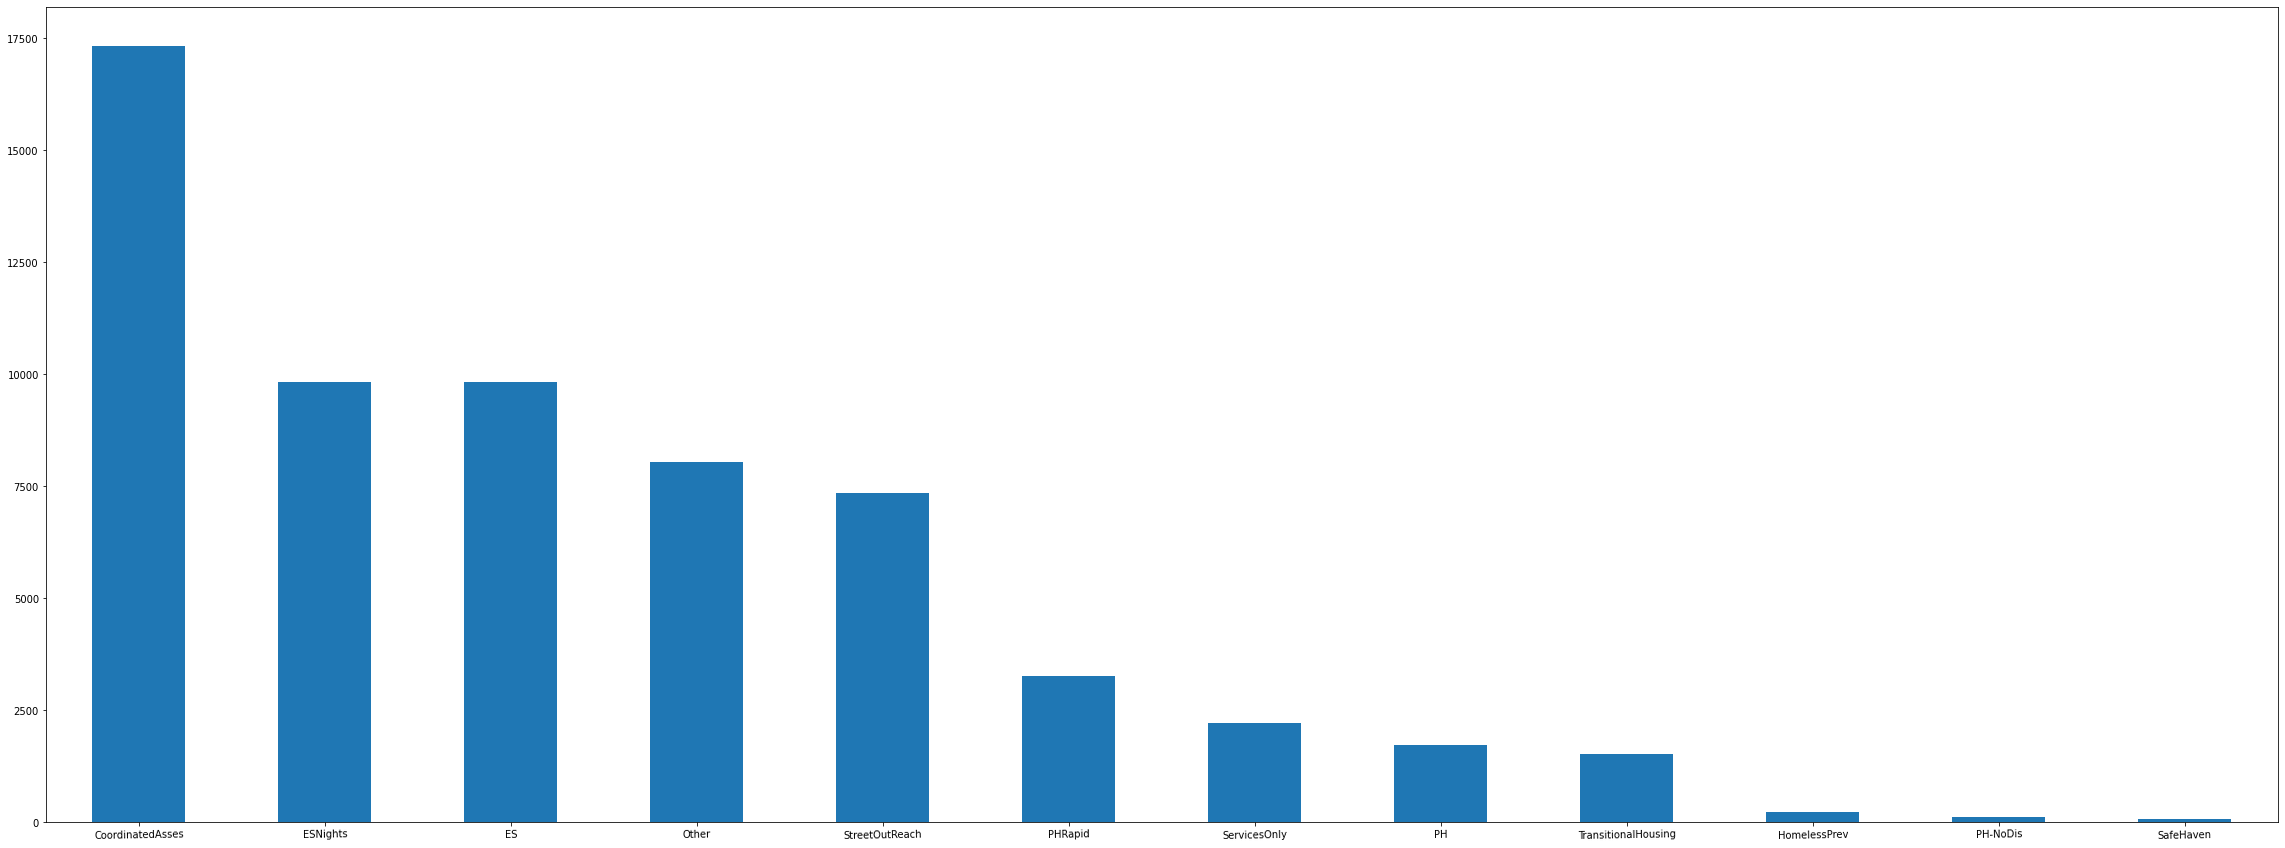

In [17]:
#graphing most used services by homeless
initial_df.groupby('personalid').count().sum().sort_values(ascending=False).plot.bar(figsize=(40, 15), rot = 1)

## Unsupervised Learning Methods

### Initial Approach with PCA, to try and see if it is possible to break down variance into principal components

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
#utilizing PCA for initial component analysis, using the MinMaxScaler Transformation

scaler = MinMaxScaler()
df_rescaled = scaler.fit_transform(df)

pca = PCA(n_components = 13)
pca.fit(df_rescaled)
reduced = pca.transform(df_rescaled)

In [19]:
#min max scaler seems to perform better than the standard scaler 
explained_variance = pca.explained_variance_ratio_
explained_variance

array([2.40007726e-01, 1.45755396e-01, 1.21881162e-01, 1.13301113e-01,
       8.23872256e-02, 7.37403977e-02, 7.17440359e-02, 4.76141421e-02,
       2.79833190e-02, 2.76329095e-02, 2.52892655e-02, 2.26633084e-02,
       6.34307344e-34])

In [20]:
#PCnames = ['PC'+str(i+1) for i in range(pca.n_components_)]

In [21]:
df.columns

Index(['ESNights', 'ES', 'TransitionalHousing', 'PH', 'StreetOutReach',
       'ServicesOnly', 'Other', 'SafeHaven', 'PH-NoDis', 'HomelessPrev',
       'PHRapid', 'CoordinatedAsses', 'TotalUsage'],
      dtype='object')

In [22]:
PCnames = ['PC'+str(i+1) for i in range(pca.n_components_)]
Loadings = pd.DataFrame(pca.components_,columns=PCnames,index=df.columns)

([<matplotlib.axis.XTick at 0x7fb32d95d650>,
 <a list of 13 Text major ticklabel objects>)

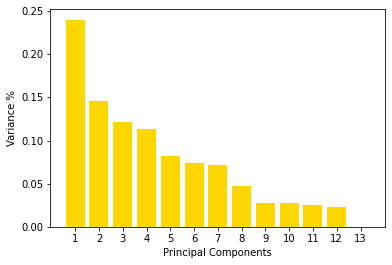

In [23]:
# Plotting the variances for each PC
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

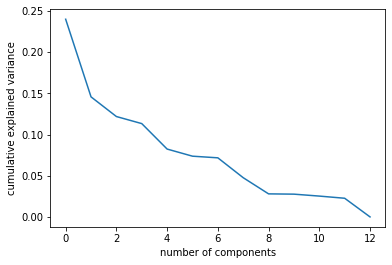

In [24]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

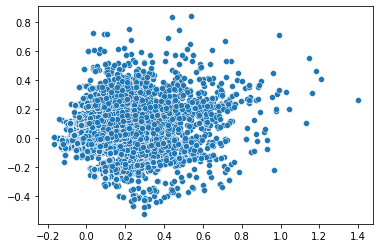

In [25]:
#from this initial plot it seems that a clear cluster forms in the principal components
sns.scatterplot(x = reduced[:, 0], y = reduced[:, 1])

In [26]:
#plotting explained variance, utilizing the plotly package
import plotly.express as px

exp_var = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var.shape[0] + 1),
    y=exp_var,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [27]:
fig = px.scatter(x=reduced[:, 0], y=reduced[:, 1])
fig.show()

### Approach Number 2 Implmenting Clustering Methods

#### Parameter Tuning Optimal Cluster Selection

Beginning k = 2
Beginning k = 3
Beginning k = 4
Beginning k = 5
Beginning k = 6
Beginning k = 7
Beginning k = 8
Beginning k = 9
Beginning k = 10
Beginning k = 11
Beginning k = 12
Beginning k = 13
Beginning k = 14
Beginning k = 15
Beginning k = 16
Beginning k = 17
Beginning k = 18
Beginning k = 19
Beginning k = 20
Beginning k = 21
Beginning k = 22
Beginning k = 23
Beginning k = 24
Beginning k = 25
Beginning k = 26
Beginning k = 27
Beginning k = 28
Beginning k = 29
Beginning k = 30
Beginning k = 31
Beginning k = 32
Beginning k = 33
Beginning k = 34
Beginning k = 35
Beginning k = 36
Beginning k = 37
Beginning k = 38
Beginning k = 39
Beginning k = 40
Beginning k = 41
Beginning k = 42
Beginning k = 43
Beginning k = 44
Beginning k = 45
Beginning k = 46
Beginning k = 47
Beginning k = 48
Beginning k = 49


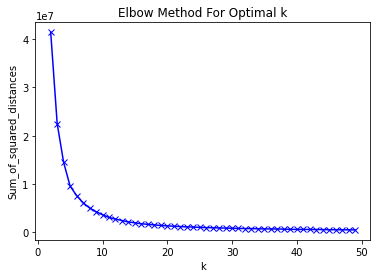

In [28]:
#importing packages
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.cluster import MeanShift

# Elbow method for assessing k number of clusters
wcss = [] # Null dataframe to store sum of squared distances
K = range(2, 50)  # Range to assess
for k in K:
    print("Beginning k = " + str(k))
    kmeans_k = KMeans(n_clusters=k).fit(df) # Fitting to k number of clusters
    wcss.append(kmeans_k.inertia_) # Storing data

# Elbow methog graphing
plt.plot(K, wcss, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [29]:
# Silhouette method - Add Later

In [30]:
# Gap Statistics - Add Later

In [31]:
# Cross - Validation - Add Later

#### Kmeans Clustering

In [32]:
kmeans = KMeans(n_clusters = 9, verbose = True).fit(df_rescaled)
kmeans_labels = kmeans.labels_ + 1
df['kmeans'] = kmeans_labels


Initialization complete
Iteration 0, inertia 1426.8400601436133
Iteration 1, inertia 1213.9815413997617
Iteration 2, inertia 1190.004086473346
Iteration 3, inertia 1185.6342412803415
Iteration 4, inertia 1184.38802153454
Iteration 5, inertia 1183.7571271173
Iteration 6, inertia 1183.3983577580038
Iteration 7, inertia 1183.1713467864254
Iteration 8, inertia 1182.999379894832
Iteration 9, inertia 1182.901593700186
Iteration 10, inertia 1182.8755292315154
Iteration 11, inertia 1182.86727189487
Iteration 12, inertia 1182.8607732569546
Iteration 13, inertia 1182.8458815067906
Iteration 14, inertia 1182.8106663138146
Iteration 15, inertia 1182.7351636246399
Iteration 16, inertia 1182.6525301030656
Iteration 17, inertia 1182.5553545916841
Iteration 18, inertia 1182.3250871805585
Iteration 19, inertia 1181.8381438796698
Iteration 20, inertia 1181.3025753932238
Iteration 21, inertia 1180.8323519525275
Iteration 22, inertia 1180.1055787355078
Iteration 23, inertia 1179.3674149145304
Iteration 24

In [33]:
#most common clusters 
df['kmeans'].value_counts()

2    10086
6     5704
8     5200
1     2542
5     1626
7     1599
3     1452
4     1022
9      114
Name: kmeans, dtype: int64

In [34]:
PrincipalComponent1 = reduced[:, 0]
PrincipalComponent2 = reduced[:, 1]

In [35]:
#visualizing the clusters, with PCA and KMeans
fig = px.scatter(x=PrincipalComponent1, y=PrincipalComponent2, color = df['kmeans'])
fig.show()

#### DBSCAN

In [36]:
dbscan = DBSCAN(eps = 2.5, min_samples = 10, n_jobs=-1).fit(df)
dbscan_labels = dbscan.labels_ + 1
df['dbscan'] = dbscan_labels

In [37]:
#visualizing the clusters, with PCA and DBSCAN
fig = px.scatter(x=PrincipalComponent1, y=PrincipalComponent2, color = df['dbscan'])
fig.show()

In [38]:
df['dbscan'].value_counts()

1     27254
0      1843
2        60
3        39
9        28
7        21
12       20
6        19
10       16
11       14
8        11
4        10
5        10
Name: dbscan, dtype: int64

#### BIRCH

In [39]:
birch = Birch(branching_factor=1000, n_clusters=9, threshold=1.5).fit(df)
birch_labels = birch.labels_+1
df['birch'] = birch_labels

In [40]:
#visualizing the clusters, with PCA and Birch
fig = px.scatter(x=PrincipalComponent1, y=PrincipalComponent2, color = df['birch'])
fig.show()

In [41]:
df['birch'].value_counts()

9    24086
1     2342
8     1702
3      503
7      494
6       88
5       54
4       47
2       29
Name: birch, dtype: int64

#### Isolation Forest, to find outliers

In [43]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(contamination = 0.01).fit(df)
df['Isolation Score'] = IF.predict(df)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



In [44]:
df['Isolation Score'].value_counts()

 1    29051
-1      294
Name: Isolation Score, dtype: int64

In [45]:
fig = px.scatter(x=PrincipalComponent1, y=PrincipalComponent2, color = df['Isolation Score'])
fig.show()

### Clustering Based on Just Total Usage

In [46]:
usage_unalter = df['TotalUsage']
usage = pd.DataFrame(usage_unalter)

Beginning k = 6
Beginning k = 7
Beginning k = 8
Beginning k = 9
Beginning k = 10
Beginning k = 11
Beginning k = 12
Beginning k = 13
Beginning k = 14
Beginning k = 15
Beginning k = 16
Beginning k = 17
Beginning k = 18
Beginning k = 19


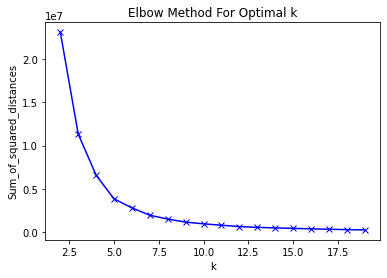

In [47]:
wcss = [] # Null dataframe to store sum of squared distances
K = range(2, 20)  # Range to assess
for k in K:
    print("Beginning k = " + str(k))
    kmeans_k = KMeans(n_clusters=k).fit(usage) # Fitting to k number of clusters
    wcss.append(kmeans_k.inertia_) # Storing data

# Elbow methog graphing
plt.plot(K, wcss, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

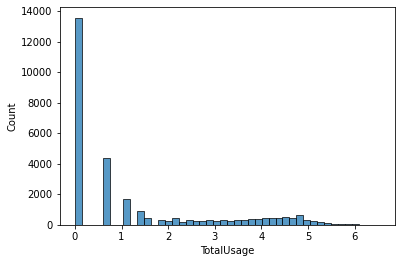

In [48]:
sns.histplot(x = np.log(df['TotalUsage']), data = df)

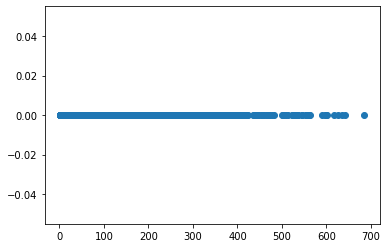

In [49]:
plot_one(usage, 'TotalUsage')

In [ ]:
kmeans = KMeans(n_clusters = 4, verbose = True).fit(usage)
kmeans_labels = kmeans.labels_ + 1
usage['kmeans'] = kmeans_labels

In [51]:
usage['kmeans'].value_counts()

2    24379
1     3133
3     1662
4      171
Name: kmeans, dtype: int64

No handles with labels found to put in legend.


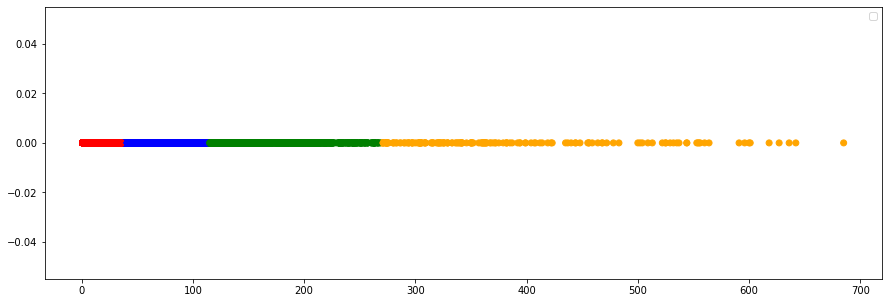

In [52]:
color = ["blue", "red", "green", 'orange']
plt.figure(figsize=(15,5))
plt.legend(loc='best')
plt.scatter(usage_unalter.values.flatten(), [0]*len(usage_unalter) , c=[color[p] for p in kmeans.labels_])

#### Kernel Density Estimation Method
Credit to https://stackoverflow.com/questions/35094454/how-would-one-use-kernel-density-estimation-as-a-1d-clustering-method-in-scikit/35151947#35151947

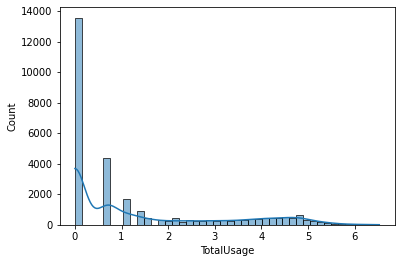

In [54]:
sns.histplot(x = np.log(usage['TotalUsage']), data = usage, kde = True)

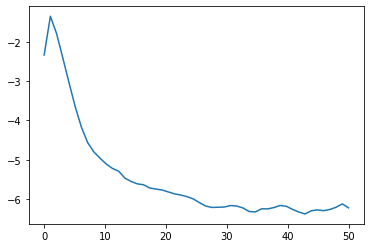

In [55]:
#applying kde method to cluster just based on total usage
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema

a = array(usage['TotalUsage']).reshape(-1, 1)
kde = KernelDensity(kernel='exponential', bandwidth=1).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

#finding maxima and minima
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]

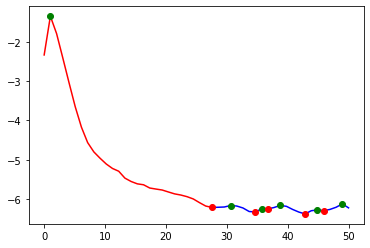

In [56]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[0]+1], e[mi[0]:mi[0]+1], 'g',
     s[mi[0]:], e[mi[0]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

#### Now Using Jenkins Natrual Breaks Optimization to cluster based on Total Usage

In [ ]:
!pip install jenkspy
import jenkspy 

In [61]:
breaks = jenkspy.jenks_breaks(usage['TotalUsage'], nb_class = 5)
breaks

[1.0, 28.0, 85.0, 164.0, 316.0, 685.0]

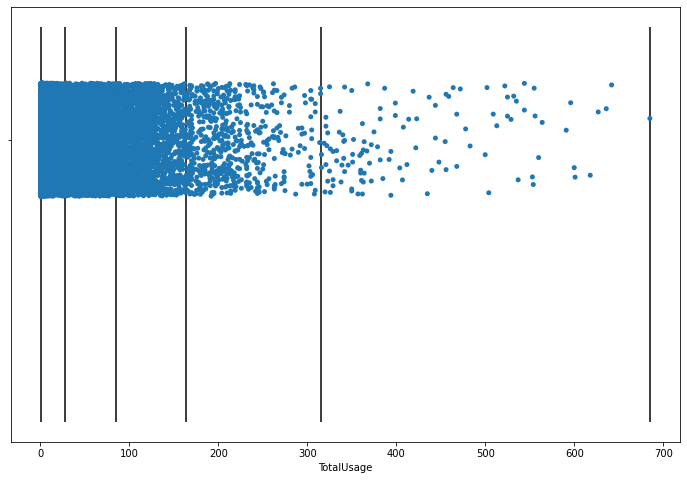

In [67]:
plt.figure(figsize=(12,8))
sns.stripplot(x = 'TotalUsage', data = usage, jitter = True, edgecolor = 'none')
sns.despine
for b in breaks: 
  plt.vlines(b, ymin=-0.2, ymax = 0.5)

### Cluster Evaluation Methods

In [ ]:
from sklearn.metrics import silhouette_score

k_means_silhouette = silhouette_score(df, df['kmeans'])
dbscan_silhouette = silhouette_score(df, df['dbscan'])


In [ ]:
sample_silhouette_values